<a href="https://colab.research.google.com/github/valvarezma/vision_artificial/blob/main/Tarea_Vision_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalar Librerias de OpenCV Jupyter

In [45]:
%%capture
!apt install libopencv-dev
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

import os
import subprocess
from IPython.display import Image
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

import os
import subprocess
from IPython.display import Image
import shutil

IMG_SIZE = 400
os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "image_1.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://picsum.photos/$IMG_SIZE.jpg &> /dev/null
Image(filename=IMG_FNAME)
#shutil.copyfile(IMG_FNAME, "imagen_1.jpg")

os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "image_2.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://picsum.photos/$IMG_SIZE.jpg &> /dev/null
Image(filename=IMG_FNAME)
#shutil.copyfile(IMG_FNAME, "imagen_2.jpg")

Brillo y contraste de imagen

In [46]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

const int block_size = 256;

__global__ void adjustBrightnessContrast(const uchar* image, uchar* result, int rows, int cols, float brightness, float contrast) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        int index = row * cols + col;
        float pixel_value = image[index];
        float adjusted_pixel_value = contrast * pixel_value + brightness;
        result[index] = (uchar) min(max(adjusted_pixel_value, 0.0f), 255.0f);
    }
}

int main() {
    // Cargar la imagen
    cv::Mat image = cv::imread("image_1.jpg", cv::IMREAD_GRAYSCALE);

    // Verificar si la imagen se cargó correctamente
    if (image.empty()) {
        std::cerr << "Error: No se pudo cargar la imagen." << std::endl;
        return 1;
    }

    // Obtener el tamaño de la imagen
    int rows = image.rows;
    int cols = image.cols;
    int total_pixels = rows * cols;

    // Calcular el tamaño del bloque y el número de bloques
    dim3 threadsPerBlock(block_size);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    // Crear punteros para la imagen y el resultado en el dispositivo
    uchar *d_image, *d_result;
    cudaMalloc(&d_image, total_pixels * sizeof(uchar));
    cudaMalloc(&d_result, total_pixels * sizeof(uchar));

    // Copiar la imagen al dispositivo
    cudaMemcpy(d_image, image.data, total_pixels * sizeof(uchar), cudaMemcpyHostToDevice);

    // Definir los valores de brillo y contraste
    float brightness = 50.0f; // Cambia este valor según lo desees
    float contrast = 1.5f;    // Cambia este valor según lo desees

    // Ajustar brillo y contraste
    adjustBrightnessContrast<<<numBlocks, threadsPerBlock>>>(d_image, d_result, rows, cols, brightness, contrast);
    cudaDeviceSynchronize();

    // Copiar el resultado de vuelta al host
    uchar* result = new uchar[total_pixels];
    cudaMemcpy(result, d_result, total_pixels * sizeof(uchar), cudaMemcpyDeviceToHost);

    // Crear imagen resultante
    cv::Mat adjusted_image(rows, cols, CV_8UC1, result);

    // Guardar la imagen resultante
    cv::imwrite("image_ajustada.jpg", adjusted_image);

    // Liberar memoria en el dispositivo
    cudaFree(d_image);
    cudaFree(d_result);

    std::cout << "El ajuste de brillo y contraste de la imagen se ha completado exitosamente." << std::endl;

    return 0;
}


El ajuste de brillo y contraste de la imagen se ha completado exitosamente.



Cambio de brillo y contraste de una imagen

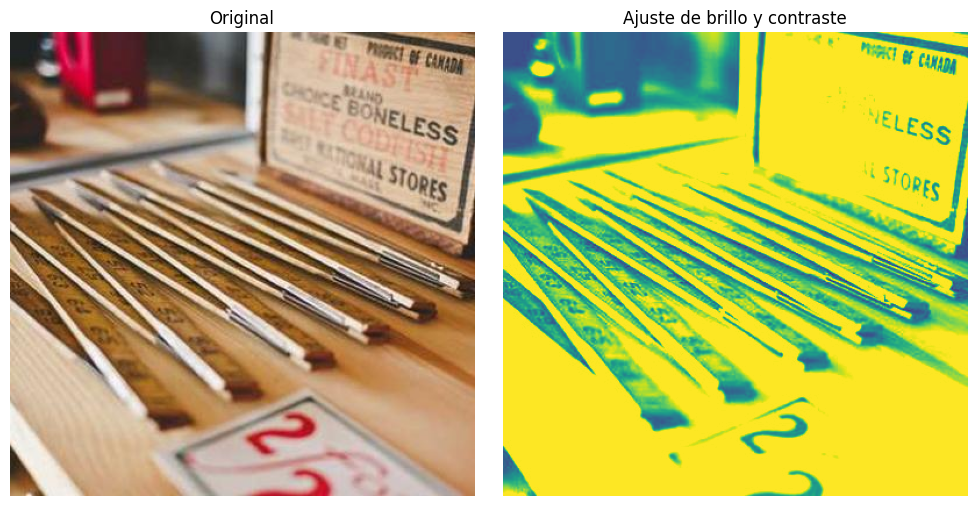

In [47]:
import matplotlib.pyplot as plt
from PIL import Image

# Carga las imágenes "antes.jpg" y "despues.jpg"
img_antes = Image.open("image_1.jpg")
img_despues = Image.open("image_ajustada.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_antes)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(img_despues)
axs[1].set_title("Ajuste de brillo y contraste")
axs[1].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Ecualización de imagen

In [34]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

const int num_bins = 256;
const int block_size = 256;

__global__ void computeHistogram(const uchar* image, int* histogram, int size) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < size) {
        atomicAdd(&histogram[image[idx]], 1);
    }
}

__global__ void computeCDF(int* histogram, float* cdf, int size, int total_pixels) {
    extern __shared__ float cdf_shared[];

    int idx = threadIdx.x;
    cdf_shared[idx] = histogram[idx] / (float)total_pixels;

    __syncthreads();

    for (int stride = 1; stride < num_bins; stride *= 2) {
        int index = 2 * stride * idx;
        if (index < num_bins) {
            cdf_shared[index] += cdf_shared[index + stride];
        }
        __syncthreads();
    }

    cdf[idx] = cdf_shared[idx];
}

__global__ void equalizeImage(const uchar* image, uchar* result, float* cdf, int size) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < size) {
        float normalized_pixel = cdf[image[idx]] * 255;
        result[idx] = (uchar) min(max((int)normalized_pixel, 0), 255);
    }
}

int main() {
    // Cargar la imagen
    cv::Mat image = cv::imread("image_1.jpg", cv::IMREAD_GRAYSCALE);

    // Verificar si la imagen se cargó correctamente
    if (image.empty()) {
        std::cerr << "Error: No se pudo cargar la imagen." << std::endl;
        return 1;
    }

    // Obtener el tamaño de la imagen
    int rows = image.rows;
    int cols = image.cols;
    int total_pixels = rows * cols;

    // Calcular el tamaño del bloque y el número de bloques
    dim3 threadsPerBlock(block_size);
    dim3 numBlocks((total_pixels + block_size - 1) / block_size);

    // Crear punteros para la imagen y el resultado en el dispositivo
    uchar *d_image, *d_result;
    cudaMalloc(&d_image, total_pixels * sizeof(uchar));
    cudaMalloc(&d_result, total_pixels * sizeof(uchar));

    // Copiar la imagen al dispositivo
    cudaMemcpy(d_image, image.data, total_pixels * sizeof(uchar), cudaMemcpyHostToDevice);

    // Crear histograma y CDF en el dispositivo
    int* d_histogram;
    float* d_cdf;
    cudaMalloc(&d_histogram, num_bins * sizeof(int));
    cudaMalloc(&d_cdf, num_bins * sizeof(float));
    cudaMemset(d_histogram, 0, num_bins * sizeof(int));

    // Calcular histograma
    computeHistogram<<<numBlocks, threadsPerBlock>>>(d_image, d_histogram, total_pixels);
    cudaDeviceSynchronize();

    // Calcular CDF
    computeCDF<<<1, num_bins, num_bins * sizeof(float)>>>(d_histogram, d_cdf, num_bins, total_pixels);
    cudaDeviceSynchronize();

    // Ecualizar imagen
    equalizeImage<<<numBlocks, threadsPerBlock>>>(d_image, d_result, d_cdf, total_pixels);
    cudaDeviceSynchronize();

    // Copiar el resultado de vuelta al host
    uchar* result = new uchar[total_pixels];
    cudaMemcpy(result, d_result, total_pixels * sizeof(uchar), cudaMemcpyDeviceToHost);

    // Crear imagen resultante
    cv::Mat equalized_image(rows, cols, CV_8UC1, result);

    // Guardar la imagen resultante
    cv::imwrite("image_ecualizada.jpg", equalized_image);

    // Liberar memoria en el dispositivo
    cudaFree(d_image);
    cudaFree(d_result);
    cudaFree(d_histogram);
    cudaFree(d_cdf);

    std::cout << "La ecualización de la imagen se ha completado exitosamente." << std::endl;

    return 0;
}


La ecualización de la imagen se ha completado exitosamente.



Visualización de resultado de ecualización de imagen

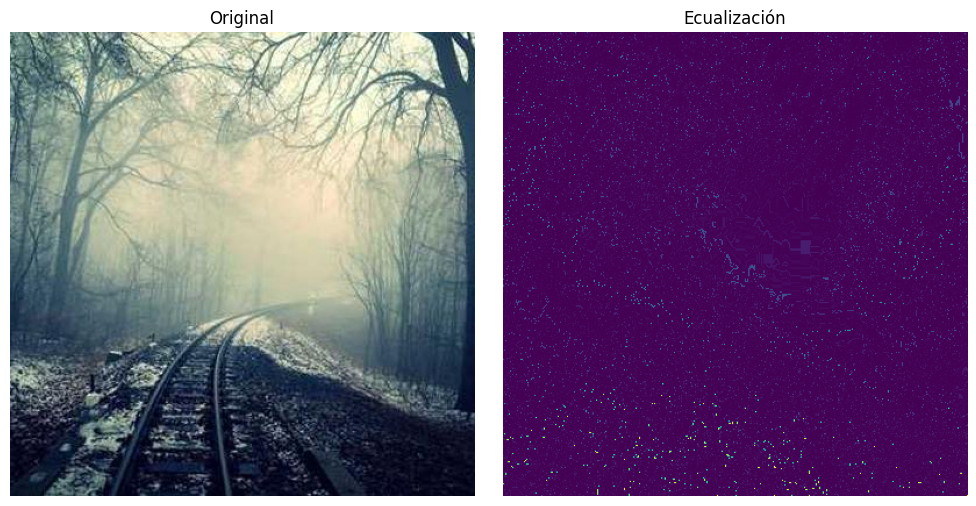

In [36]:
import matplotlib.pyplot as plt
from PIL import Image

img_antes = Image.open("image_1.jpg")
img_despues = Image.open("image_ecualizada.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_antes)
axs[0].set_title("Original")
axs[0].axis("off")


axs[1].imshow(img_despues)
axs[1].set_title("Ecualización")
axs[1].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Suma de 2 imagenes

In [24]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

const int block_size = 16;

__global__ void imageAdd(const uchar* img1, const uchar* img2, uchar* result, int rows, int cols, int channels) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        int index = (row * cols + col) * channels;
        for (int i = 0; i < channels; ++i) {
            int idx = index + i;
            result[idx] = img1[idx] + img2[idx];
        }
    }
}

int main() {
    // Cargar las imágenes
    cv::Mat image1 = cv::imread("image_1.jpg", cv::IMREAD_COLOR);
    cv::Mat image2 = cv::imread("image_2.jpg", cv::IMREAD_COLOR);

    // Verificar si las imágenes se cargaron correctamente
    if (image1.empty() || image2.empty()) {
        std::cerr << "Error: No se pudieron cargar las imágenes." << std::endl;
        return 1;
    }

    // Verificar si las imágenes tienen el mismo tamaño
    if (image1.size() != image2.size()) {
        std::cerr << "Error: Las imágenes tienen tamaños diferentes." << std::endl;
        return 1;
    }

    // Obtener las dimensiones de las imágenes
    int rows = image1.rows;
    int cols = image1.cols;
    int channels = image1.channels();

    // Crear matrices para las imágenes en el dispositivo
    uchar *d_img1, *d_img2, *d_result;
    cudaMalloc(&d_img1, rows * cols * channels * sizeof(uchar));
    cudaMalloc(&d_img2, rows * cols * channels * sizeof(uchar));
    cudaMalloc(&d_result, rows * cols * channels * sizeof(uchar));

    // Copiar datos desde el host al dispositivo
    cudaMemcpy(d_img1, image1.data, rows * cols * channels * sizeof(uchar), cudaMemcpyHostToDevice);
    cudaMemcpy(d_img2, image2.data, rows * cols * channels * sizeof(uchar), cudaMemcpyHostToDevice);

    // Lanzar el kernel para sumar las imágenes
    dim3 threadsPerBlock(block_size, block_size);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);
    imageAdd<<<numBlocks, threadsPerBlock>>>(d_img1, d_img2, d_result, rows, cols, channels);

    // Copiar el resultado desde el dispositivo al host
    cv::Mat result(rows, cols, CV_8UC3);
    cudaMemcpy(result.data, d_result, rows * cols * channels * sizeof(uchar), cudaMemcpyDeviceToHost);

    // Guardar la imagen resultante
    cv::imwrite("image_resultante.jpg", result);

    // Liberar memoria en el dispositivo
    cudaFree(d_img1);
    cudaFree(d_img2);
    cudaFree(d_result);

    std::cout << "La suma de las imágenes se ha completado exitosamente." << std::endl;

    return 0;
}


La suma de las imágenes se ha completado exitosamente.



Visualización de resultado de suma de 2 imagenes

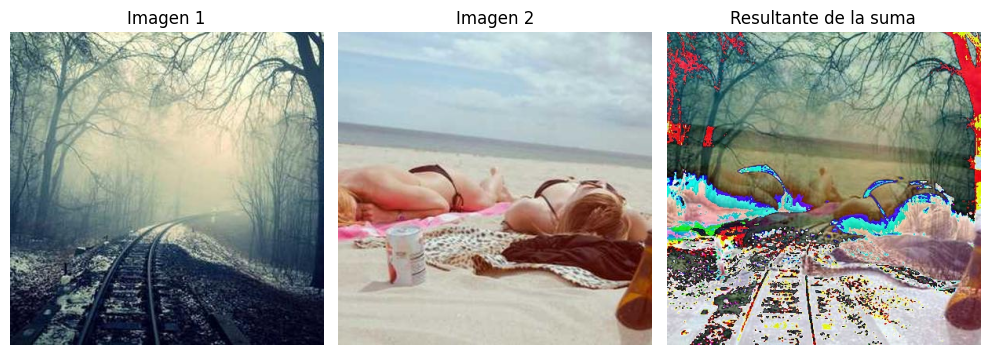

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

img_1 = Image.open("image_1.jpg")
img_2 = Image.open("image_2.jpg")
img_suma = Image.open("image_resultante.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(img_1)
axs[0].set_title("Imagen 1")
axs[0].axis("off")

axs[1].imshow(img_2)
axs[1].set_title("Imagen 2")
axs[1].axis("off")

# Muestra la imagen resultante
axs[2].imshow(img_suma)
axs[2].set_title("Resultante de la suma")
axs[2].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Resta de dos imagenes

In [28]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

const int block_size = 16;

__global__ void imageSubtract(const uchar* img1, const uchar* img2, uchar* result, int rows, int cols, int channels) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        int index = (row * cols + col) * channels;
        for (int i = 0; i < channels; ++i) {
            int idx = index + i;
            result[idx] = img1[idx] - img2[idx];
        }
    }
}

int main() {
    // Cargar las imágenes
    cv::Mat image1 = cv::imread("image_1.jpg", cv::IMREAD_COLOR);
    cv::Mat image2 = cv::imread("image_2.jpg", cv::IMREAD_COLOR);

    // Verificar si las imágenes se cargaron correctamente
    if (image1.empty() || image2.empty()) {
        std::cerr << "Error: No se pudieron cargar las imágenes." << std::endl;
        return 1;
    }

    // Verificar si las imágenes tienen el mismo tamaño
    if (image1.size() != image2.size()) {
        std::cerr << "Error: Las imágenes tienen tamaños diferentes." << std::endl;
        return 1;
    }

    // Obtener las dimensiones de las imágenes
    int rows = image1.rows;
    int cols = image1.cols;
    int channels = image1.channels();

    // Crear matrices para las imágenes en el dispositivo
    uchar *d_img1, *d_img2, *d_result;
    cudaMalloc(&d_img1, rows * cols * channels * sizeof(uchar));
    cudaMalloc(&d_img2, rows * cols * channels * sizeof(uchar));
    cudaMalloc(&d_result, rows * cols * channels * sizeof(uchar));

    // Copiar datos desde el host al dispositivo
    cudaMemcpy(d_img1, image1.data, rows * cols * channels * sizeof(uchar), cudaMemcpyHostToDevice);
    cudaMemcpy(d_img2, image2.data, rows * cols * channels * sizeof(uchar), cudaMemcpyHostToDevice);

    // Lanzar el kernel para restar las imágenes
    dim3 threadsPerBlock(block_size, block_size);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);
    imageSubtract<<<numBlocks, threadsPerBlock>>>(d_img1, d_img2, d_result, rows, cols, channels);

    // Copiar el resultado desde el dispositivo al host
    cv::Mat result(rows, cols, CV_8UC3);
    cudaMemcpy(result.data, d_result, rows * cols * channels * sizeof(uchar), cudaMemcpyDeviceToHost);

    // Guardar la imagen resultante
    cv::imwrite("imagen_resultante_resta.jpg", result);

    // Liberar memoria en el dispositivo
    cudaFree(d_img1);
    cudaFree(d_img2);
    cudaFree(d_result);

    std::cout << "La resta de las imágenes se ha completado exitosamente." << std::endl;

    return 0;
}


La resta de las imágenes se ha completado exitosamente.



Visualización de resultado de resta de 2 imagenes

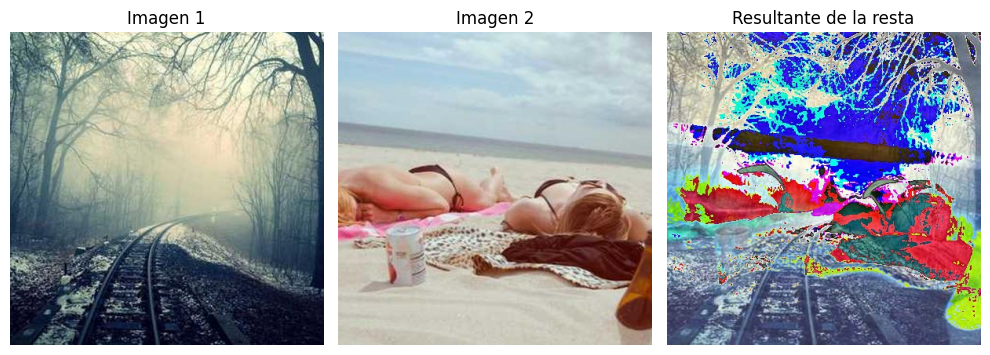

In [31]:
import matplotlib.pyplot as plt
from PIL import Image

img_1 = Image.open("image_1.jpg")
img_2 = Image.open("image_2.jpg")
img_resta = Image.open("imagen_resultante_resta.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(img_1)
axs[0].set_title("Imagen 1")
axs[0].axis("off")

axs[1].imshow(img_2)
axs[1].set_title("Imagen 2")
axs[1].axis("off")

# Muestra la imagen resultante
axs[2].imshow(img_resta)
axs[2].set_title("Resultante de la resta")
axs[2].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Convolución de una imagen

In [37]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

const int block_size = 16;

__constant__ float kernel[3][3] = {
    { -1, -1, -1 },
    { -1,  8, -1 },
    { -1, -1, -1 }
};

__global__ void applyConvolution(const uchar* input, uchar* output, int rows, int cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        float pixel_value = 0.0f;
        for (int i = -1; i <= 1; ++i) {
            for (int j = -1; j <= 1; ++j) {
                int row_idx = min(max(row + i, 0), rows - 1);
                int col_idx = min(max(col + j, 0), cols - 1);
                pixel_value += input[row_idx * cols + col_idx] * kernel[i + 1][j + 1];
            }
        }
        output[row * cols + col] = min(max((int)pixel_value, 0), 255);
    }
}

int main() {
    // Cargar la imagen
    cv::Mat image = cv::imread("image_1.jpg", cv::IMREAD_GRAYSCALE);

    // Verificar si la imagen se cargó correctamente
    if (image.empty()) {
        std::cerr << "Error: No se pudo cargar la imagen." << std::endl;
        return 1;
    }

    // Obtener el tamaño de la imagen
    int rows = image.rows;
    int cols = image.cols;
    int total_pixels = rows * cols;

    // Calcular el tamaño del bloque y el número de bloques
    dim3 threadsPerBlock(block_size, block_size);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    // Crear punteros para la imagen y el resultado en el dispositivo
    uchar *d_input, *d_output;
    cudaMalloc(&d_input, total_pixels * sizeof(uchar));
    cudaMalloc(&d_output, total_pixels * sizeof(uchar));

    // Copiar la imagen al dispositivo
    cudaMemcpy(d_input, image.data, total_pixels * sizeof(uchar), cudaMemcpyHostToDevice);

    // Aplicar convolución
    applyConvolution<<<numBlocks, threadsPerBlock>>>(d_input, d_output, rows, cols);
    cudaDeviceSynchronize();

    // Copiar el resultado de vuelta al host
    uchar* result = new uchar[total_pixels];
    cudaMemcpy(result, d_output, total_pixels * sizeof(uchar), cudaMemcpyDeviceToHost);

    // Crear imagen resultante
    cv::Mat convolved_image(rows, cols, CV_8UC1, result);

    // Guardar la imagen resultante
    cv::imwrite("image_convolucionada.jpg", convolved_image);

    // Liberar memoria en el dispositivo
    cudaFree(d_input);
    cudaFree(d_output);

    std::cout << "La convolución de la imagen se ha completado exitosamente." << std::endl;

    return 0;
}


La convolución de la imagen se ha completado exitosamente.



Visualización de resultado de convolución de imagen

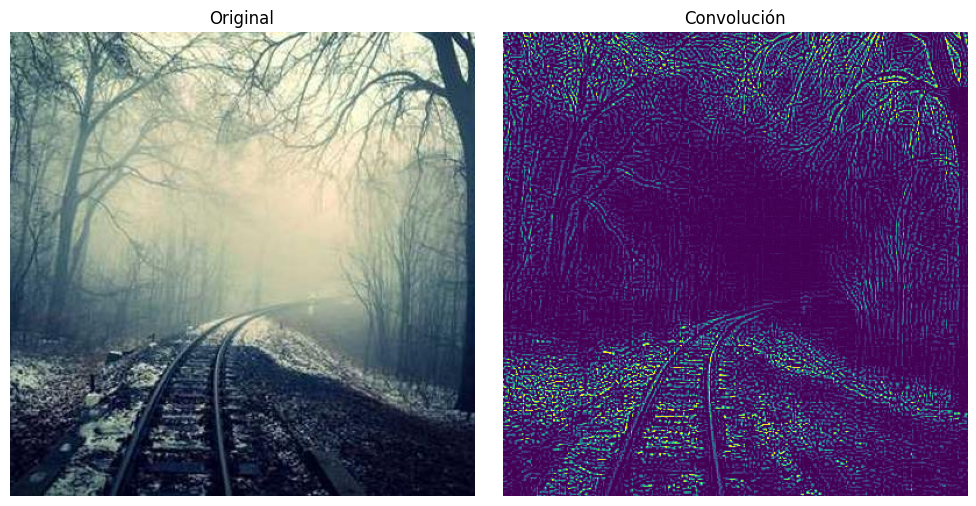

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

img_antes = Image.open("image_1.jpg")
img_despues = Image.open("image_convolucionada.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_antes)
axs[0].set_title("Original")
axs[0].axis("off")


axs[1].imshow(img_despues)
axs[1].set_title("Convolución")
axs[1].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Consiguiendo imagenes para el Template Maching:

Imagen A: Espacio de busqueda, Imagen B: Imagen buscada

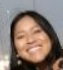

In [50]:
import os
import subprocess
from IPython.display import Image
import shutil

IMG_SIZE = 400
os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "imagen_a.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://raw.githubusercontent.com/valvarezma/vision_artificial/main/imagen_a.jpg &> /dev/null
Image(filename=IMG_FNAME)

os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "imagen_b.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://raw.githubusercontent.com/valvarezma/vision_artificial/main/imagen_b.jpg &> /dev/null
Image(filename=IMG_FNAME)

### Template Matching

In [53]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

__global__ void templateMatching(const uchar* input, const uchar* template_img, float* result, int input_rows, int input_cols, int template_rows, int template_cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < input_rows - template_rows && col < input_cols - template_cols) {
        float sum = 0.0f;
        float input_mean = 0.0f;
        float template_mean = 0.0f;

        // Calcular la media de la imagen de entrada y de la plantilla
        for (int i = 0; i < template_rows; ++i) {
            for (int j = 0; j < template_cols; ++j) {
                input_mean += input[(row + i) * input_cols + (col + j)];
                template_mean += template_img[i * template_cols + j];
            }
        }
        input_mean /= (template_rows * template_cols);
        template_mean /= (template_rows * template_cols);

        // Calcular la correlación cruzada normalizada (NCC)
        for (int i = 0; i < template_rows; ++i) {
            for (int j = 0; j < template_cols; ++j) {
                float input_pixel = input[(row + i) * input_cols + (col + j)];
                float template_pixel = template_img[i * template_cols + j];
                sum += (input_pixel - input_mean) * (template_pixel - template_mean);
            }
        }
        result[row * (input_cols - template_cols) + col] = sum;
    }
}

int main() {
    cv::Mat input_image = cv::imread("imagen_a.jpg", cv::IMREAD_GRAYSCALE);
    cv::Mat template_image = cv::imread("imagen_b.jpg", cv::IMREAD_GRAYSCALE);

    if (input_image.empty() || template_image.empty()) {
        std::cerr << "Error: No se pudieron cargar las imágenes." << std::endl;
        return 1;
    }

    int input_rows = input_image.rows;
    int input_cols = input_image.cols;
    int template_rows = template_image.rows;
    int template_cols = template_image.cols;

    uchar *d_input, *d_template;
    float *d_result;

    cudaMalloc(&d_input, input_rows * input_cols * sizeof(uchar));
    cudaMalloc(&d_template, template_rows * template_cols * sizeof(uchar));
    cudaMalloc(&d_result, (input_rows - template_rows) * (input_cols - template_cols) * sizeof(float));

    cudaMemcpy(d_input, input_image.data, input_rows * input_cols * sizeof(uchar), cudaMemcpyHostToDevice);
    cudaMemcpy(d_template, template_image.data, template_rows * template_cols * sizeof(uchar), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((input_cols - template_cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (input_rows - template_rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    templateMatching<<<numBlocks, threadsPerBlock>>>(d_input, d_template, d_result, input_rows, input_cols, template_rows, template_cols);
    cudaDeviceSynchronize();

    float* result = new float[(input_rows - template_rows) * (input_cols - template_cols)];
    cudaMemcpy(result, d_result, (input_rows - template_rows) * (input_cols - template_cols) * sizeof(float), cudaMemcpyDeviceToHost);

    // Encontrar la ubicación de la mejor coincidencia
    float max_val = -FLT_MAX;
    cv::Point best_match;
    for (int i = 0; i < input_rows - template_rows; ++i) {
        for (int j = 0; j < input_cols - template_cols; ++j) {
            if (result[i * (input_cols - template_cols) + j] > max_val) {
                max_val = result[i * (input_cols - template_cols) + j];
                best_match = cv::Point(j, i);
            }
        }
    }

    // Dibujar el recuadro en la imagen de entrada
    cv::rectangle(input_image, best_match, cv::Point(best_match.x + template_cols, best_match.y + template_rows), cv::Scalar(0, 255, 0), 2);

    // Mostrar la imagen con el recuadro

    cv::imwrite("image_template.jpg", input_image);
    cv::waitKey(0);
    cv::destroyAllWindows();

    delete[] result;
    cudaFree(d_input);
    cudaFree(d_template);
    cudaFree(d_result);

    return 0;
}


Visualización de resultado de Template Maching

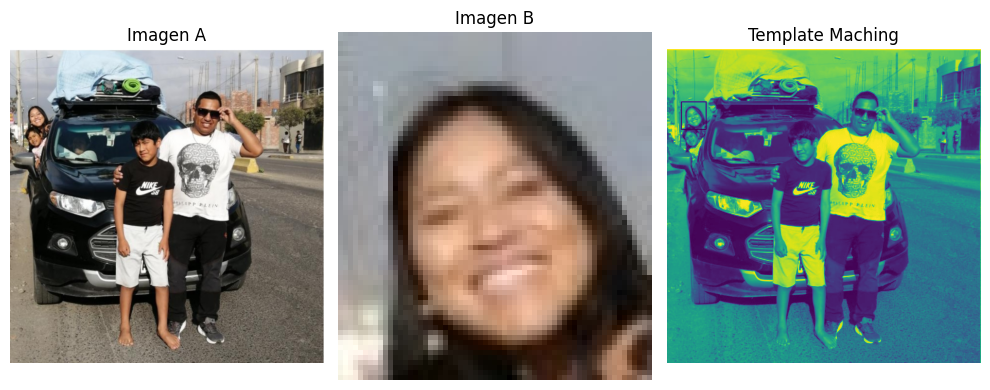

In [57]:
import matplotlib.pyplot as plt
from PIL import Image

img_1 = Image.open("imagen_a.jpg")
img_2 = Image.open("imagen_b.jpg")
img_template = Image.open("image_template.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(img_1)
axs[0].set_title("Imagen A")
axs[0].axis("off")

axs[1].imshow(img_2)
axs[1].set_title("Imagen B")
axs[1].axis("off")

# Muestra la imagen resultante
axs[2].imshow(img_template)
axs[2].set_title("Template Maching")
axs[2].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

(Extra) Blurring de una imagen

In [19]:

%%cuda --compiler-args "$COMPILER_ARGS"

#include <opencv2/core.hpp>
#include <opencv2/imgcodecs.hpp>

#include <iostream>

#define BLUR_SIZE 5
#define R 0
#define G 1
#define B 2

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)

// kernel taken from https://stackoverflow.com/a/65973288
__global__ void blurKernel(
    unsigned char* in,
    unsigned char* out,
    int width,
    int height,
    int num_channel,
    int channel
) {

    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if(col < width && row < height) {
        int pixVal = 0;
        int pixels = 0;
        for(int blurRow = -BLUR_SIZE; blurRow < BLUR_SIZE + 1; ++blurRow) {
            for(int blurCol = -BLUR_SIZE; blurCol < BLUR_SIZE + 1; ++blurCol) {
                int curRow = row + blurRow;
                int curCol = col + blurCol;
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
                    pixVal += in[curRow * width * num_channel + curCol * num_channel + channel];
                    pixels++;
                }
            }
        }
        out[row * width * num_channel + col * num_channel + channel] = (unsigned char)(pixVal/pixels);
    }
}

int main()
{

    std::string image_path = cv::samples::findFile("image_1.jpg");
    cv::Mat img = imread(image_path, cv::IMREAD_COLOR);
    if(img.empty())
    {
        std::cerr << "Could not read the image: " << image_path << std::endl;
        return 1;
    }

    // image shape
    int width = img.cols;
    int height = img.rows;
    int n_channels = 3; // hard-coded RGB processing

    // we will read and write directly into the data array of the OpenCV Matrix
    unsigned char *host_image_input = img.data;
    unsigned char *host_image_output = img.data;

    // allocate memory for device arrays
    unsigned char* dev_image_input = NULL;
    unsigned char* dev_image_output = NULL;
    cudaMalloc(
        (void**)&dev_image_input,
        sizeof(unsigned char) * height * width * n_channels
    );
    cudaMalloc(
        (void**)&dev_image_output,
        sizeof(unsigned char) * height * width * n_channels
    );
    cudaCheckErrors("cudaMalloc failure");

    // transfer data from host to device for processing on GPU
    cudaMemcpy(
        dev_image_input,
        host_image_input,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyHostToDevice
    );
    cudaCheckErrors("cudaMemcpy H2D failure");

    // run a blur kernel on each channel
    dim3 blockSize(16, 16, 1);
    dim3 gridSize(width/blockSize.x, height/blockSize.y, 1);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, R);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, G);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, B);

    cudaDeviceSynchronize();
    cudaCheckErrors("kernel failure");

    // copy results back to host
    cudaMemcpy(
        host_image_output,
        dev_image_output,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyDeviceToHost
    );
    cudaCheckErrors("cudaMemcpy D2H failure");

    cudaFree(dev_image_input);
    cudaFree(dev_image_output);

    // save the blurred image to disk
    cv::imwrite("image_blurred.jpg", img);

    return 0;
}

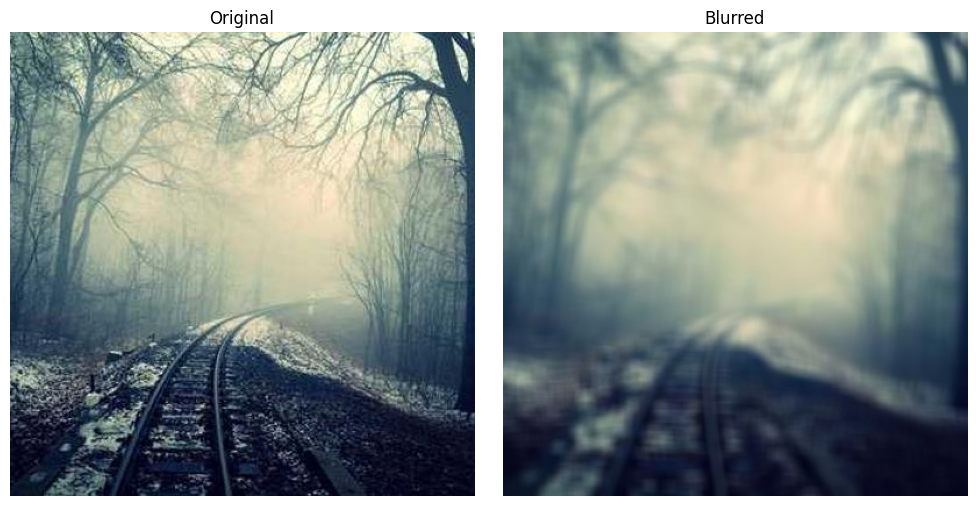

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

# Carga las imágenes "antes.jpg" y "despues.jpg"
img_antes = Image.open("image_1.jpg")
img_despues = Image.open("image_blurred.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Muestra la imagen "antes" en el primer subplot
axs[0].imshow(img_antes)
axs[0].set_title("Original")
axs[0].axis("off")

# Muestra la imagen "después" en el segundo subplot
axs[1].imshow(img_despues)
axs[1].set_title("Blurred")
axs[1].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Filtro Gaussiano

In [58]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

const int block_size = 16;

__constant__ float gaussian_kernel[5][5] = {
    {1, 4,  6,  4, 1},
    {4, 16, 24, 16, 4},
    {6, 24, 36, 24, 6},
    {4, 16, 24, 16, 4},
    {1, 4,  6,  4, 1}
};

__global__ void applyGaussianFilter(const uchar* input, uchar* output, int rows, int cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        float pixel_value = 0.0f;
        for (int i = -2; i <= 2; ++i) {
            for (int j = -2; j <= 2; ++j) {
                int row_idx = min(max(row + i, 0), rows - 1);
                int col_idx = min(max(col + j, 0), cols - 1);
                pixel_value += input[row_idx * cols + col_idx] * gaussian_kernel[i + 2][j + 2];
            }
        }
        output[row * cols + col] = min(max((int)(pixel_value / 256.0f), 0), 255);
    }
}

int main() {
    // Cargar la imagen
    cv::Mat image = cv::imread("image_1.jpg", cv::IMREAD_GRAYSCALE);

    // Verificar si la imagen se cargó correctamente
    if (image.empty()) {
        std::cerr << "Error: No se pudo cargar la imagen." << std::endl;
        return 1;
    }

    // Obtener el tamaño de la imagen
    int rows = image.rows;
    int cols = image.cols;
    int total_pixels = rows * cols;

    // Calcular el tamaño del bloque y el número de bloques
    dim3 threadsPerBlock(block_size, block_size);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    // Crear punteros para la imagen y el resultado en el dispositivo
    uchar *d_input, *d_output;
    cudaMalloc(&d_input, total_pixels * sizeof(uchar));
    cudaMalloc(&d_output, total_pixels * sizeof(uchar));

    // Copiar la imagen al dispositivo
    cudaMemcpy(d_input, image.data, total_pixels * sizeof(uchar), cudaMemcpyHostToDevice);

    // Aplicar filtro gaussiano
    applyGaussianFilter<<<numBlocks, threadsPerBlock>>>(d_input, d_output, rows, cols);
    cudaDeviceSynchronize();

    // Copiar el resultado de vuelta al host
    uchar* result = new uchar[total_pixels];
    cudaMemcpy(result, d_output, total_pixels * sizeof(uchar), cudaMemcpyDeviceToHost);

    // Crear imagen resultante
    cv::Mat filtered_image(rows, cols, CV_8UC1, result);

    // Guardar la imagen resultante
    cv::imwrite("image_gauss.jpg", filtered_image);

    // Liberar memoria en el dispositivo
    cudaFree(d_input);
    cudaFree(d_output);

    std::cout << "El filtro gaussiano de la imagen se ha completado exitosamente." << std::endl;

    return 0;
}

El filtro gaussiano de la imagen se ha completado exitosamente.



Visualización de resultado de Filtro Gaussiano

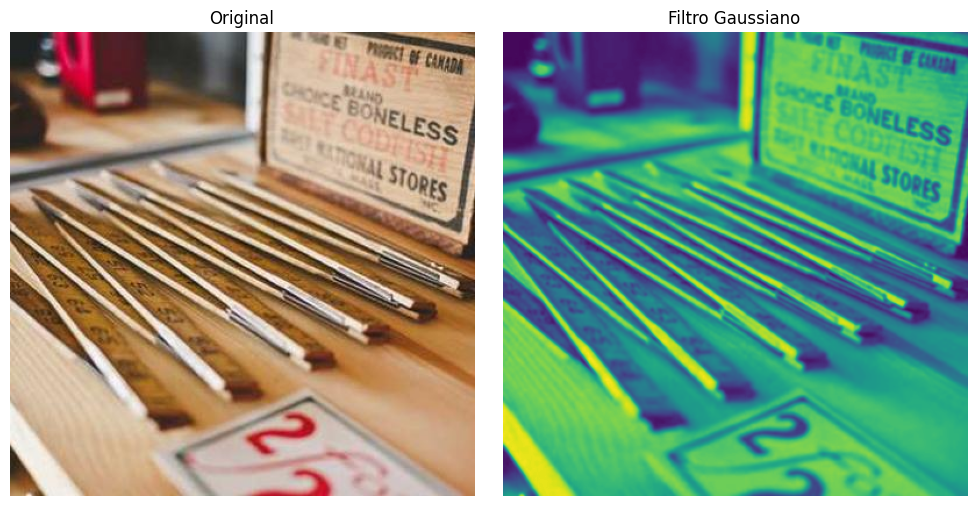

In [59]:
import matplotlib.pyplot as plt
from PIL import Image

img_antes = Image.open("image_1.jpg")
img_despues = Image.open("image_gauss.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_antes)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(img_despues)
axs[1].set_title("Filtro Gaussiano")
axs[1].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()